<a href="https://colab.research.google.com/github/erichardson97/ROC_vs_PR/blob/main/ROC_vs_PR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, precision_score, recall_score, average_precision_score, roc_curve
import seaborn as sns
from matplotlib import pyplot as plt, patches as mpatches
from matplotlib.patches import ConnectionPatch
from matplotlib.lines import Line2D
from itertools import combinations
from google.colab import drive
import os
from scipy import stats
from statistics import NormalDist
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
sns.set(style = 'white', font_scale = 1.5)

In [4]:
# @title Figure directory

figure_dir = '.'
if os.path.exists(figure_dir) is False:
  os.mkdir(figure_dir)

In [5]:
# @title Mutable parameters for simulated datasets.

sizes = 10000

imbalances = [.01, 0.1, 0.5]

mean_diffs = [0.5, 1, 1.5]

n_repeats = 1000

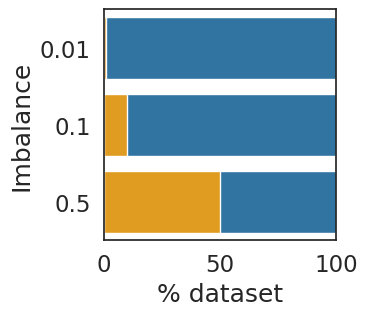

In [6]:
# @title Plot of imbalances
stacked_bar = {'imbalance':[],'positive':[],'negative':[]}
for imbalance in imbalances:
  ones = np.ones(int(imbalance*100))
  zeros = np.zeros(100-int(imbalance*100))
  stacked_bar['imbalance'] += [imbalance]
  stacked_bar['positive'] += [len(ones)]
  stacked_bar['negative'] += [len(zeros)]
stacked_bar = pd.DataFrame(stacked_bar)
stacked_bar['total'] = stacked_bar['positive'] + stacked_bar['negative']
fig, ax = plt.subplots(1,1,figsize=(3,len(imbalances)))
sns.barplot(x="total", y="imbalance", data=stacked_bar,
            label="Negative", color='#1f77b4', edgecolor='white', orient = 'h', ax = ax)
sns.barplot(x="positive",y="imbalance", data=stacked_bar,
            label="Positive", color="orange", edgecolor='white', orient = 'h',ax=ax)
ax.set_ylabel('Imbalance',fontsize=18)
ax.set_xlabel('% dataset',fontsize=18)
ax.set_xlim(0,100)
plt.savefig(os.path.join(figure_dir, 'DataSplit.png'), dpi = 600, bbox_inches = 'tight')

In [39]:
# @title Drawing score distribution
def draw_distrib(size, imbalance,  mean):
  n_pos = int(size * imbalance)
  scores = np.random.normal(0, 1, size)
  scores[:n_pos] = np.random.normal(mean, 1, n_pos)
  labels = np.zeros(size)
  labels[:n_pos] = 1
  return labels, scores

def er_distrib(size, imbalance, er = 'good'):
  n_pos = int(size * imbalance)
  size = size
  labels = np.zeros(size)
  labels[:n_pos] = 1
  if er == 'good':
     scores = np.random.beta(1, 4, size)
     scores[:n_pos] = np.random.beta(1, 1, n_pos)
  else:
    scores = np.random.beta(1, 1, size)
    scores[:n_pos] = np.random.beta(4, 1, n_pos)
  return labels, scores


def pr_estimate_table(n_repeats, mean_diffs, imbalances, size = 10000,  n_pos = 100):
  repeats = {}
  for n in range(n_repeats):
    repeats[n] = {}
    for imbalance in imbalances:
      for mean in mean_diffs:
        repeats[n][(imbalance, mean)] = draw_distrib(size, imbalance, mean)
  pr_estimates = {'imbalance':[], 'PR-AUC':[], 'ROC-AUC':[], 'ROC-AUC_0.1':[], 'repeat':[], 'mean_diff':[]}
  for n in repeats:
    for imbalance in imbalances:
      estimates = {}
      for mean in mean_diffs:
          estimates[mean] = average_precision_score(*repeats[n][(imbalance, mean)]), roc_auc_score(*repeats[n][(imbalance, mean)]), roc_auc_score(*repeats[n][(imbalance, mean)], max_fpr = .1)
      for mean in mean_diffs:
        pr_estimates['imbalance'].append(imbalance)
        pr_estimates['PR-AUC'].append(estimates[mean][0])
        pr_estimates['ROC-AUC'].append(estimates[mean][1])
        pr_estimates['repeat'].append(n)
        pr_estimates['mean_diff'].append(mean)
        pr_estimates['ROC-AUC_0.1'].append(estimates[mean][-1])
  return pd.DataFrame(pr_estimates), repeats


def pr_estimate_table_beta(n_repeats, imbalances, size = 10000, simulation_type = 1, n_pos = 100):
  repeats = {}
  for n in range(n_repeats):
    repeats[n] = {}
    for imbalance in imbalances:
      for er in ['good','bad']:
        labels, scores = er_distrib(size, imbalance, er)
        repeats[n][(imbalance, er)] = labels, scores
  pr_estimates = {'imbalance':[], 'PR-AUC':[], 'ROC-AUC':[], 'ROC-AUC_0.1':[], 'repeat':[], 'mean_diff':[]}
  for n in repeats:
    for imbalance in imbalances:
      for er in ['good','bad']:
        pr_estimates['imbalance'].append(imbalance)
        pr_estimates['PR-AUC'].append(average_precision_score(*repeats[n][(imbalance, er)]))
        pr_estimates['ROC-AUC'].append(roc_auc_score(*repeats[n][(imbalance, er)]))
        pr_estimates['ROC-AUC_0.1'].append(roc_auc_score(*repeats[n][(imbalance, er)], max_fpr = .1))
        pr_estimates['mean_diff'].append(er)
        pr_estimates['repeat'].append(n)
  return pd.DataFrame(pr_estimates), repeats


def calc_pr_estimates_diff(pr_estimates, means, norm = True):
  pr_estimates_diff = {'mean_diff':[],'lower_ci':[],'upper_ci':[],'p1':[],'p2':[],'imbalance':[],'metric':[],'sem':[],'err':[],'n':[]}
  for k,p in pr_estimates.groupby('imbalance'):
    for p1, p2 in combinations(means, 2):
      vals1 = p[p['mean_diff']==p1]
      vals2 = p[p['mean_diff']==p2]
      for key in ['ROC-AUC','PR-AUC','ROC-AUC_0.1']:
        vals_1 = vals1[key].values
        vals_2 = vals2[key].values
        diff = (vals_1 - vals_2)/vals_2 if norm else vals_1 - vals_2
        mean = np.mean(diff)
        sem = stats.sem(diff)
        tstat = stats.t(df = len(diff) - 1).ppf((1 + 0.95) /2)
        W = tstat * np.std(diff, ddof=1) / np.sqrt(len(diff))
        pr_estimates_diff['mean_diff'].append(mean)
        pr_estimates_diff['lower_ci'].append(mean-sem*2)
        pr_estimates_diff['upper_ci'].append(mean+sem*2)
        pr_estimates_diff['sem'].append(sem)
        pr_estimates_diff['p1'].append(p1)
        pr_estimates_diff['p2'].append(p2)
        pr_estimates_diff['imbalance'].append(k)
        pr_estimates_diff['metric'].append(key)
        pr_estimates_diff['err'].append(W)
        pr_estimates_diff['n'].append(len(diff))
  pr_estimates_diff = pd.DataFrame(pr_estimates_diff)
  return pr_estimates_diff

In [12]:
pr_estimates, datasets = pr_estimate_table(n_repeats, mean_diffs, imbalances)
pr_estimates['PR-AUC_Marginal'] = pr_estimates['PR-AUC'] - pr_estimates['imbalance']
pr_estimates['PR-AUC_Ratio'] = pr_estimates['PR-AUC_Marginal']**2 / (pr_estimates['imbalance'])
pr_estimates['Classifier type'] = pr_estimates['mean_diff'].map(lambda x:'Worst' if x==0.5 else 'Middle' if x== 1 else 'Best')
pr_estimates_er, datasets_er = pr_estimate_table_beta(n_repeats,  imbalances)
pr_estimates_er['PR-AUC_Marginal'] = pr_estimates_er['PR-AUC'] - pr_estimates_er['imbalance']
pr_estimates_er['PR-AUC_Ratio'] = pr_estimates_er['PR-AUC_Marginal']**2 / (pr_estimates_er['imbalance'])

In [46]:
pr_estimates_diff = calc_pr_estimates_diff(pr_estimates, mean_diffs)
# pr_estimates_diff['p1'] = pr_estimates_diff['p1'] .map(lambda x:'Worst' if x==0.5 else 'Middle' if x== 1 else 'Best')
# pr_estimates_diff['p2'] = pr_estimates_diff['p2'] .map(lambda x:'Worst' if x==0.5 else 'Middle' if x== 1 else 'Best')

pr_estimates_diff_er = calc_pr_estimates_diff(pr_estimates_er, ['Good', 'Bad'])
# pr_estimates_diff_er['p1'] = pr_estimates_diff_er['p1'] .map(lambda x:'Worst' if x==0.5 else 'Middle' if x== 1 else 'Best')
# pr_estimates_diff_er['p2'] = pr_estimates_diff_er['p2'] .map(lambda x:'Worst' if x==0.5 else 'Middle' if x== 1 else 'Best')


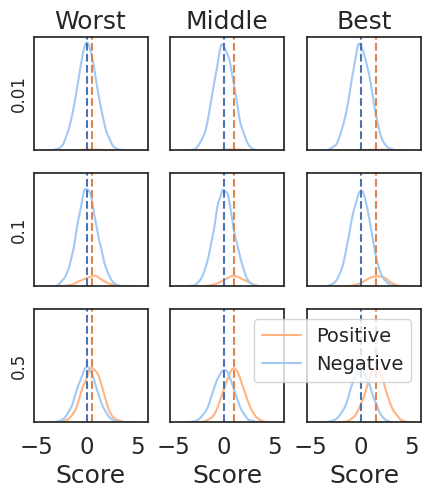

In [13]:
fig, axs = plt.subplots(len(imbalances), len(mean_diffs),figsize=(5,5),sharex=True,sharey=True)
repeat = np.random.randint(n_repeats)
for n,imbalance in enumerate(imbalances):
  for k, i in enumerate(mean_diffs):
    ax = axs[n][k]
    sns.kdeplot(pd.DataFrame(datasets[repeat][(imbalance, i)]).T, x = 1, hue = 0, palette='pastel', common_norm=True, ax=ax, legend=False)
    ax.set_xlabel('Score')
    axs[0][k].set_title(['Worst','Middle','Best'][k])
    ax.axvline(0,linestyle='--',color='C0')
    ax.axvline(i,linestyle='--',color='C1')
for n,imbalance in enumerate(imbalances):
  axs[n][0].set_yticks([])
  axs[n][0].set_ylabel(imbalance, rotation = 90, fontsize = 12)
plt.legend(['Positive','Negative'], fontsize = 14)
plt.savefig(os.path.join(figure_dir, f'DistributionCheck_TotalNorm.png'), dpi=600, bbox_inches='tight')

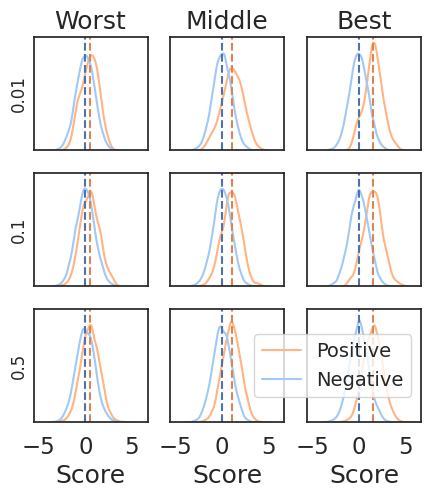

In [14]:
fig, axs = plt.subplots(len(imbalances), len(mean_diffs),figsize=(5,5),sharex=True,sharey=True)
repeat = np.random.randint(n_repeats)
for n,imbalance in enumerate(imbalances):
  for k, i in enumerate(mean_diffs):
    ax = axs[n][k]
    sns.kdeplot(pd.DataFrame(datasets[repeat][(imbalance, i)]).T, x = 1, hue = 0, palette='pastel', common_norm=False, ax=ax, legend=False)
    ax.set_xlabel('Score')
    axs[0][k].set_title(['Worst','Middle','Best'][k])
    ax.axvline(0,linestyle='--',color='C0')
    ax.axvline(i,linestyle='--',color='C1')
for n,imbalance in enumerate(imbalances):
  axs[n][0].set_yticks([])
  axs[n][0].set_ylabel(imbalance, rotation = 90, fontsize = 12)
plt.legend(['Positive','Negative'], fontsize = 14)
plt.savefig(os.path.join(figure_dir, f'DistributionCheck_PerClassNorm.png'), dpi=600, bbox_inches='tight')

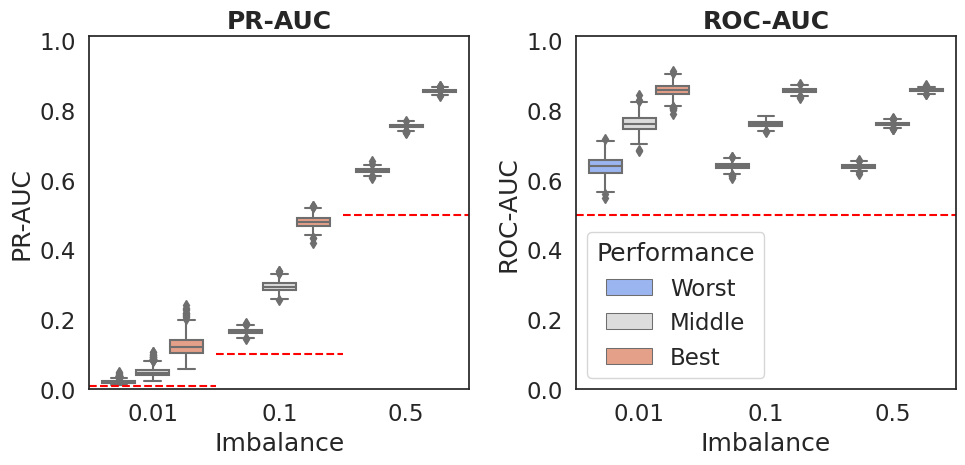

In [15]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
sns.boxplot(data = pr_estimates[pr_estimates['mean_diff'].isin(mean_diffs)], x='imbalance', y ='PR-AUC', hue = 'Classifier type', ax = axs[0], palette = 'coolwarm')
axs[0].set_xlabel('Imbalance')
axs[0].set_ylim(0,1.01)
axs[0].set_ylabel('PR-AUC')
axs[0].set_title(f"PR-AUC",weight='bold')
axs[0].get_legend().remove()
total_size = len(imbalances)
for k in range(len(imbalances)):
  imbalance = imbalances[k]
  axs[0].axhline(imbalance,color='red',xmin=k/total_size+0., xmax=k/total_size+(1/total_size), linestyle='--')

sns.boxplot(data = pr_estimates[pr_estimates['mean_diff'].isin(mean_diffs)], x='imbalance', y ='ROC-AUC', hue = 'Classifier type', ax = axs[1], palette = 'coolwarm')
axs[1].set_xlabel('Imbalance')
axs[1].get_legend().set_title('Mean difference')
axs[1].set_ylim(0,1.01)
axs[1].set_ylabel('ROC-AUC')
axs[1].set_title(f"ROC-AUC",weight='bold')
axs[1].axhline(0.5,linestyle='--',color='red')
axs[1].get_legend().set_title('Performance')

# sns.boxplot(data = pr_estimates[pr_estimates['mean_diff'].isin(mean_diffs))], x='imbalance', y ='ROC-AUC_0.1', hue = 'mean_diff', ax = axs[2], palette = 'coolwarm')
# axs[2].set_xlabel('Imbalance')
# axs[2].set_ylim(0,1.01)
# axs[2].set_ylabel('ROC-AUC_0.1')
# axs[2].set_title(f"ROC-AUC_0.1",weight='bold')
# axs[2].get_legend().remove()
# axs[2].axhline(0.5,linestyle='--',color='k')

fig.tight_layout()
plt.savefig(os.path.join(figure_dir, f'Fig1.png'), dpi = 600, bbox_inches = 'tight')

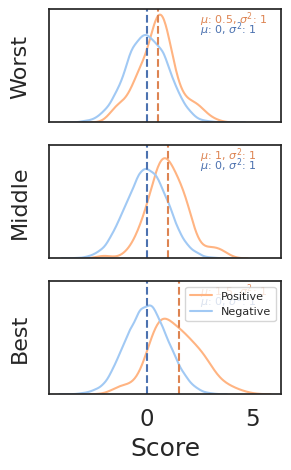

In [16]:
fig, axs = plt.subplots(len(mean_diffs), 1, figsize=(3,5), sharey=True, sharex=True)
repeat = np.random.randint(n_repeats)
for k,p in enumerate(axs):
  mean_diff = mean_diffs[k]
  sns.kdeplot(pd.DataFrame(datasets[repeat][(.01, mean_diff)]).T, x = 1, hue = 0, palette='pastel', common_norm=False, ax=p, legend=False)
  axs[k].set_ylabel(['Worst','Middle','Best'][k], size=16, rotation=90)
  axs[k].axvline(mean_diff, color = 'C1', linestyle = '--')
  axs[k].axvline(0, color = 'C0', linestyle = '--')
for ax in axs:
  ax.set_yticklabels([])
ax_size = ax.get_ylim()
top_right = ax_size[1] - (0.12*(ax_size[1]-ax_size[0]))
for k,p in enumerate(axs):
  axs[k].text(2.5, y = top_right, s = f'$\mu$: {mean_diffs[k]}, $\sigma^2$: 1',size=8, color = 'C1')
  axs[k].text(2.5, y = top_right*0.9, s = f'$\mu$: 0, $\sigma^2$: 1',size=8, color = 'C0')
plt.legend(['Positive','Negative'], fontsize=8)
p.set_xlabel('Score')
plt.savefig(os.path.join(figure_dir,f'Fig1_Inlay.png'), dpi = 600, bbox_inches = 'tight')

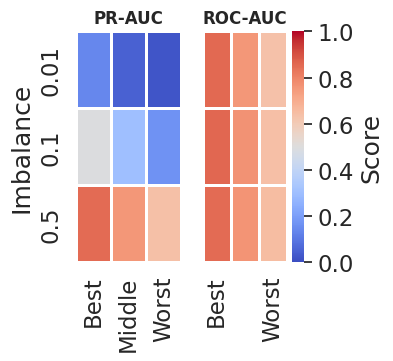

In [19]:
def plot_dual_heatmap(pr_estimates):
  fig, axs = plt.subplots(1,2, figsize=(3,3),sharey=True)
  repeat = np.random.randint(len(datasets))
  sns.heatmap(pr_estimates[pr_estimates['repeat']==repeat].pivot(columns='imbalance', index='Classifier type', values='PR-AUC').T, ax = axs[0], cmap='coolwarm',cbar=False,edgecolor='white', linewidth=1,vmin=0,vmax=1)
  sns.heatmap(pr_estimates[pr_estimates['repeat']==repeat].pivot(columns='imbalance', index='Classifier type', values='ROC-AUC').T, ax = axs[1], cmap='coolwarm', edgecolor='white',linewidth=1,vmax=1,vmin=0,cbar_kws ={'label':'Score'})
  axs[1].set_ylabel('')
  axs[0].set_ylabel('Imbalance')
  axs[0].set_xlabel('')
  axs[1].set_xlabel('')
  axs[0].set_title('PR-AUC',fontweight='bold',fontsize=12)
  axs[1].set_title('ROC-AUC',fontweight='bold',fontsize=12)
  # axs[1].set_xticks([0.5, 1.5, 2.5],['Good','Mediocre','Poor'])
  # axs[0].set_xticks([0.5, 1.5, 2.5],['Good','Mediocre','Poor'])
  for tick in axs[1].get_xticklabels():
    tick.set_rotation(90)

plot_dual_heatmap(pr_estimates)
plt.savefig(os.path.join(figure_dir,f'HeatmapInlay.png'), dpi = 600, bbox_inches = 'tight')

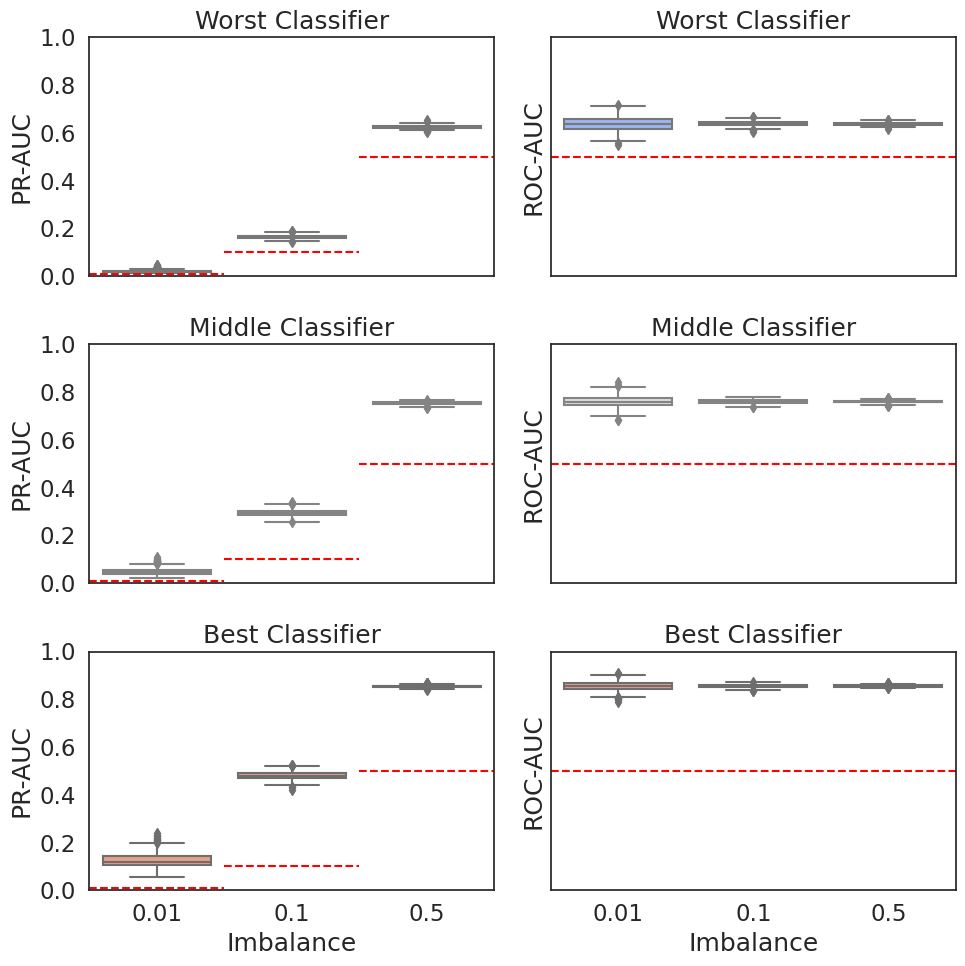

In [20]:
fig, axs = plt.subplots(3,2,figsize=(10,10),sharey=True,sharex=True)
colors = sns.color_palette("coolwarm", n_colors=3)
for n, mean_diff in enumerate(mean_diffs):
  classifier_type = ['Worst','Middle','Best'][n]
  range_line = (0.5, 0.8) #this was specified manually
  sns.boxplot(data = pr_estimates[pr_estimates['mean_diff']==mean_diff], x='imbalance', y='PR-AUC', color=colors[n], ax = axs[n][0])
  axs[n][0].set_xlabel('Imbalance')
  axs[n][0].set_ylim(0, 1)
  axs[n][0].set_title(f'{classifier_type} Classifier')
  sns.boxplot(data = pr_estimates[pr_estimates['mean_diff']==mean_diff], x='imbalance', y='ROC-AUC', color=colors[n], ax = axs[n][1])
  axs[n][1].set_xlabel('Imbalance')
  axs[n][1].set_title(f'{classifier_type} Classifier')
  for k in range(len(imbalances)):
    imbalance = imbalances[k]
    axs[n][0].axhline(imbalance,color='red',xmin=k/total_size, xmax=k/total_size+(1/total_size),linestyle='--')
  axs[n][0].set_ylim(0,1)
  axs[n][1].set_ylim(0,1)
  axs[n][1].axhline(0.5, color='red', linestyle='--')
  if n < len(mean_diffs) - 1:
    axs[n][0].set_xlabel('')
    axs[n][1].set_xlabel('')
  # axs[n][1].axhline(range_line[0],color='red',linestyle='--')
  # axs[n][1].axhline(range_line[1],color='red',linestyle='--')
  fig.tight_layout()
plt.savefig(os.path.join(figure_dir, f'Figure2_{classifier_type}.png'), dpi = 600, bbox_inches = 'tight')

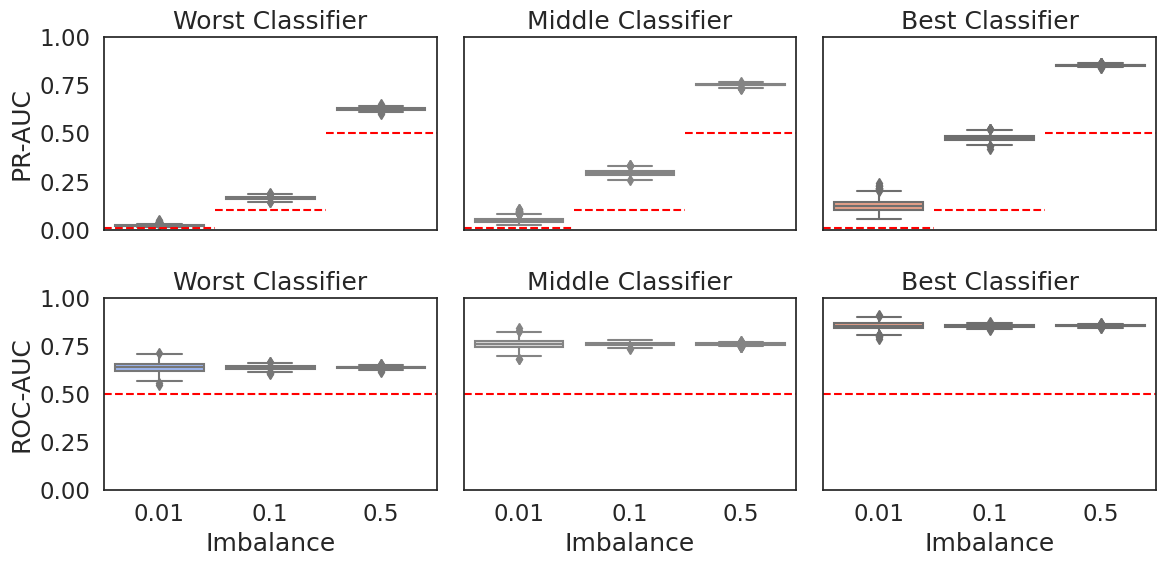

In [21]:
fig, axs = plt.subplots(2,3,figsize=(12,6),sharey=True,sharex=True)
colors = sns.color_palette("coolwarm", n_colors=3)
for n, mean_diff in enumerate(mean_diffs):
  classifier_type = ['Worst','Middle','Best'][n]
  range_line = (0.5, 0.8) #this was specified manually
  sns.boxplot(data = pr_estimates[pr_estimates['mean_diff']==mean_diff], x='imbalance', y='PR-AUC', color=colors[n], ax = axs[0][n])
  axs[0][n].set_xlabel('Imbalance')
  axs[0][n].set_ylim(0, 1)
  axs[0][n].set_title(f'{classifier_type} Classifier')
  sns.boxplot(data = pr_estimates[pr_estimates['mean_diff']==mean_diff], x='imbalance', y='ROC-AUC', color=colors[n], ax = axs[1][n])
  axs[1][n].set_xlabel('Imbalance')
  axs[1][n].set_title(f'{classifier_type} Classifier')
  axs[1][n].set_ylim(range_line[0]-0.01,range_line[1]+.01)
  for k in range(len(imbalances)):
    imbalance = imbalances[k]
    axs[0][n].axhline(imbalance,color='red',xmin=k/total_size, xmax=k/total_size+(1/total_size),linestyle='--')
  axs[0][n].set_ylim(0,1)
  axs[1][n].set_ylim(0,1)
  axs[1][n].axhline(0.5, color='red', linestyle='--')
  axs[0][n].set_xlabel('')
  if n != 0:
    axs[0][n].set_ylabel('')
    axs[1][n].set_ylabel('')
  # axs[n][1].axhline(range_line[0],color='red',linestyle='--')
  # axs[n][1].axhline(range_line[1],color='red',linestyle='--')
fig.tight_layout()
plt.savefig(os.path.join(figure_dir, f'Figure2_Alternative.png'), dpi = 600, bbox_inches = 'tight')

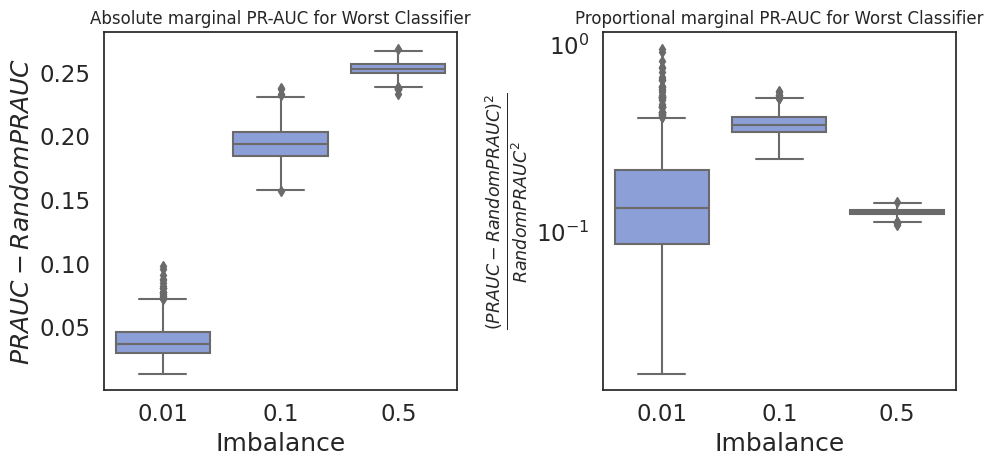

In [22]:
mean_diff = 1
classifier_type = 'Worst'
range_line = (0.6,0.88)
fig, axs = plt.subplots(1,2,figsize=(10,5))
sns.boxplot(data = pr_estimates[pr_estimates['mean_diff']==mean_diff], x='imbalance', y ='PR-AUC_Ratio', color='#8099e2', ax = axs[1])
axs[1].set_xlabel('Imbalance')
axs[1].set_title(f'Proportional marginal PR-AUC for {classifier_type} Classifier', size = 12)
axs[1].set_yscale('log')
axs[1].set_ylabel(r'$\frac{(PRAUC - Random PRAUC)^2}{Random PRAUC^2}$')
sns.boxplot(data = pr_estimates[pr_estimates['mean_diff']==mean_diff], x='imbalance', y ='PR-AUC_Marginal', color='#8099e2', ax = axs[0])
axs[0].set_xlabel('Imbalance')
axs[0].set_title(f'Absolute marginal PR-AUC for {classifier_type} Classifier', size = 12)
axs[0].set_ylabel(r'$PRAUC - Random PRAUC$')
fig.tight_layout()
plt.savefig(os.path.join(figure_dir, f'Relative{mean_diff}_Absolute.png'), dpi=600, bbox_inches = 'tight')

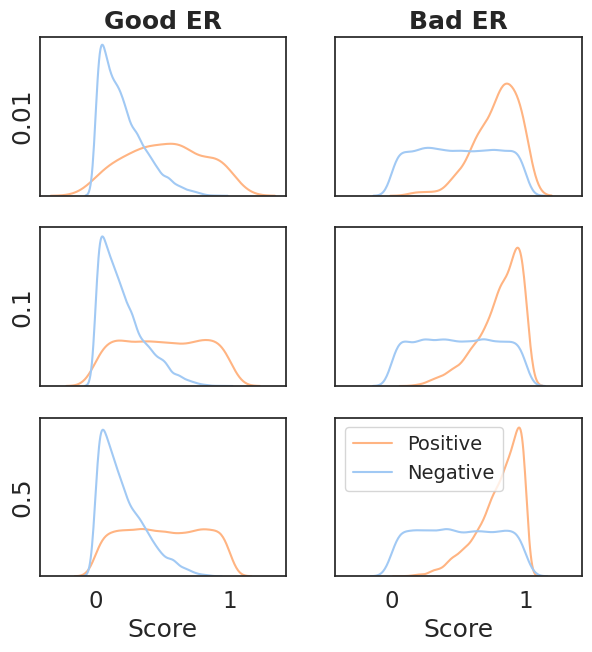

In [23]:
fig, axs = plt.subplots(len(imbalances),2,figsize=(7,7),sharex=True,sharey=True)
repeat = np.random.randint(n_repeats)
for n,imbalance in enumerate(imbalances):
  for k in range(0,2):
    ax = axs[n][k]
    sns.kdeplot(pd.DataFrame(datasets_er[repeat][(imbalance, ['good','bad'][k])]).T,  x = 1, hue = 0, palette='pastel', common_norm=False, ax=ax, legend=False)
    axs[k][0].set_ylabel(k+1,rotation=0)
    ax.set_xlabel('Score')
    axs[0][k].set_title(['Good','Bad'][k] + ' ER', weight = 'bold')
for n,imbalance in enumerate(imbalances):
  axs[n][0].set_yticks([])
  axs[n][0].set_ylabel(imbalance, rotation = 90)
plt.legend(['Positive','Negative'], fontsize=14)
plt.savefig(os.path.join(figure_dir, f'Figure4A.png'),dpi=600,bbox_inches='tight')

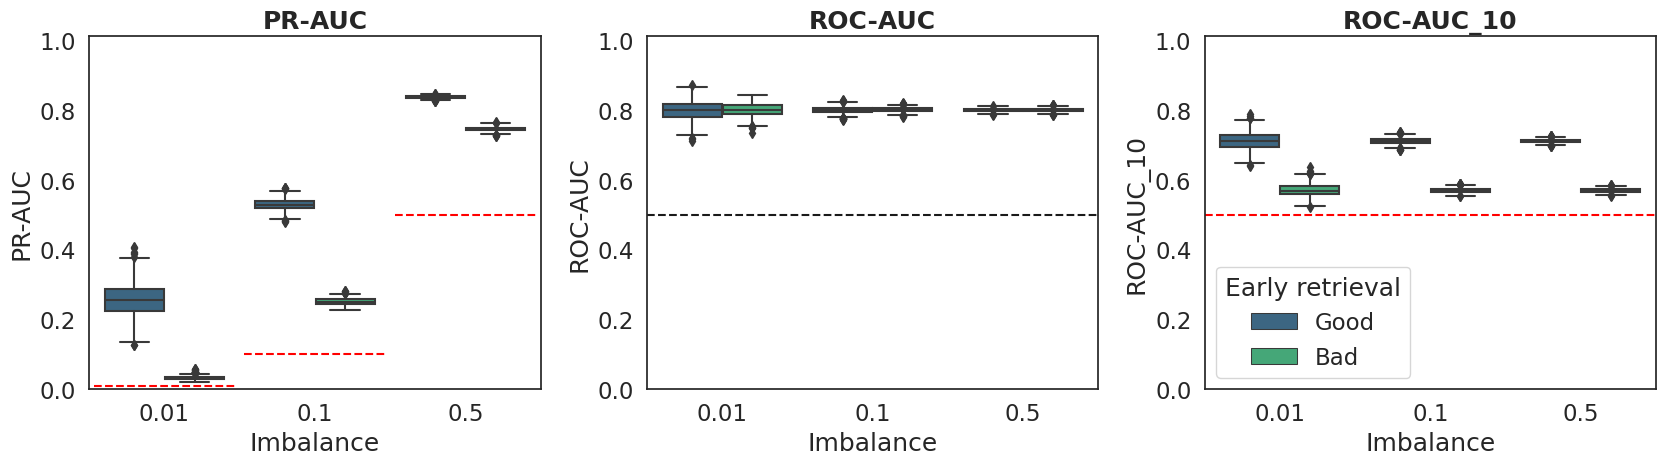

In [24]:
fig, axs = plt.subplots(1,3,figsize=(17,5))
pr_estimates_er['mean_diff'] = pr_estimates_er['mean_diff'].map(lambda x:x.capitalize())
sns.boxplot(data = pr_estimates_er, x='imbalance', y ='PR-AUC', hue = 'mean_diff', ax = axs[0], palette = 'viridis')
axs[0].set_xlabel('Imbalance')
axs[0].set_ylim(0,1.01)
axs[0].set_ylabel('PR-AUC')
axs[0].get_legend().remove()
axs[0].set_title(f"PR-AUC",weight='bold')
total_size = len(imbalances)
for k in range(len(imbalances)):
  imbalance = imbalances[k]
  axs[0].axhline(imbalance,color='red',xmin=k/total_size+0.01, xmax=k/total_size+(1/total_size)-0.01,linestyle='--')

sns.boxplot(data = pr_estimates_er, x='imbalance', y ='ROC-AUC', hue = 'mean_diff', ax = axs[1], palette = 'viridis')
axs[1].get_legend().set_title('Early retrieval')
axs[1].set_xlabel('Imbalance')
axs[1].set_ylim(0,1.01)
axs[1].set_ylabel('ROC-AUC')
axs[1].set_title(f"ROC-AUC",weight='bold')
axs[1].axhline(0.5,linestyle='--',color='k')
axs[1].get_legend().remove()

sns.boxplot(data = pr_estimates_er, x='imbalance', y ='ROC-AUC_0.1', hue = 'mean_diff', ax = axs[2], palette = 'viridis')
axs[2].get_legend().set_title('Early retrieval')
axs[2].set_xlabel('Imbalance')
axs[2].set_ylim(0,1.01)
axs[2].set_ylabel('ROC-AUC_10')
axs[2].set_title(f"ROC-AUC_10",weight='bold')
axs[2].axhline(0.5,linestyle='--',color='red')
fig.tight_layout()
plt.savefig(os.path.join(figure_dir, f'Figure4C.png'), dpi = 600, bbox_inches = 'tight')

In [50]:
pr_estimates_diff['p']

0     0.5_1.0
1     0.5_1.0
3     0.5_1.5
4     0.5_1.5
6     1.0_1.5
7     1.0_1.5
9     0.5_1.0
10    0.5_1.0
12    0.5_1.5
13    0.5_1.5
15    1.0_1.5
16    1.0_1.5
18    0.5_1.0
19    0.5_1.0
21    0.5_1.5
22    0.5_1.5
24    1.0_1.5
25    1.0_1.5
Name: p, dtype: object

In [52]:
 pr_estimates_diff[pr_estimates_diff['p']==comparison]

,mean_diff,lower_ci,upper_ci,p1,p2,imbalance,metric,sem,err,n,p


In [51]:
comparison

'0.5_1'

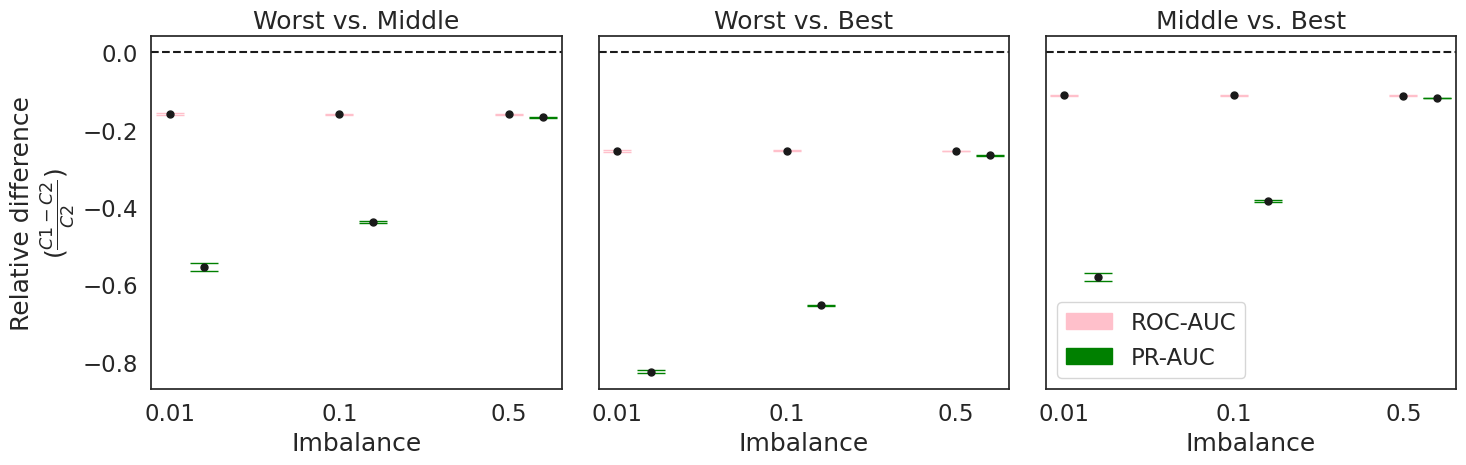

In [53]:
norm = True
mean_diffs = [float(p) for p in mean_diffs]
classifier_labels = dict((p,['Worst','Middle','Best'][k]) for k,p in enumerate(mean_diffs))
pairs = [f'{x}_{y}' for x,y in combinations(mean_diffs, 2)]
n_pairs = len(pairs)
fig, axs = plt.subplots(1, n_pairs, figsize=(15,5), sharey=True)
ylabel = 'Relative difference\n'+r"$(\frac{C1 - C2}{C2})$" if norm == True else 'Mean difference (worse classifier -\n better classifier)'
pr_estimates_diff = pr_estimates_diff[pr_estimates_diff['metric']!='ROC-AUC_0.1']
pr_estimates_diff['p'] = pr_estimates_diff['p1'].map(str)+'_'+pr_estimates_diff['p2'].map(str)

for n, comparison in enumerate(pairs):
  mean_list = list(pr_estimates_diff[pr_estimates_diff['p']==comparison]['mean_diff'].values)
  W_list = list(pr_estimates_diff[pr_estimates_diff['p']==comparison]['err'].values)
  ax=axs[n]
  metric_types = ['ROC-AUC','PR-AUC']
  colors = ['pink','green']
  index = .75
  imbalances = [.01]
  x_coords = [index]
  first_balance = pr_estimates_diff[pr_estimates_diff['p']==comparison].iloc[0]['imbalance']
  for x,(k,p) in enumerate(pr_estimates_diff[pr_estimates_diff['p']==comparison].iterrows()):
      color = colors[metric_types.index(p.metric)]
      if x != 0:

        if p.imbalance != first_balance:
          index += 1
          imbalances.append(p.imbalance)
          x_coords.append(index)
        else:
          index += .25

        first_balance = p.imbalance
      ax.errorbar(y=[p.mean_diff], x=index, yerr=[p.err], fmt='o', ms=5, color='k',capthick=1,ecolor=color,capsize=10)
  ax.axhline(0,linestyle='--',color='k')
  ax.set_xticks(x_coords, imbalances)
  red_patch = mpatches.Patch(color='pink', label='ROC-AUC')
  pink_patch = mpatches.Patch(color='green', label='PR-AUC')
  plt.legend(handles = [red_patch,pink_patch])
  ax.set_xlabel('Imbalance')
  if x == 0:
    ax.set_ylabel(ylabel)
  compared = sorted([float(p) for p in comparison.split('_')])
  ax.set_title(f'{classifier_labels[compared[0]]} vs. {classifier_labels[compared[1]]}')
axs[0].set_ylabel(ylabel)
fig.tight_layout()
if norm == False:
  plt.savefig(os.path.join(figure_dir, f'Figure3_nonorm.png'), dpi = 600, bbox_inches = 'tight')
else:
  plt.savefig(os.path.join(figure_dir, f'Figure3.png'), dpi = 600, bbox_inches = 'tight')

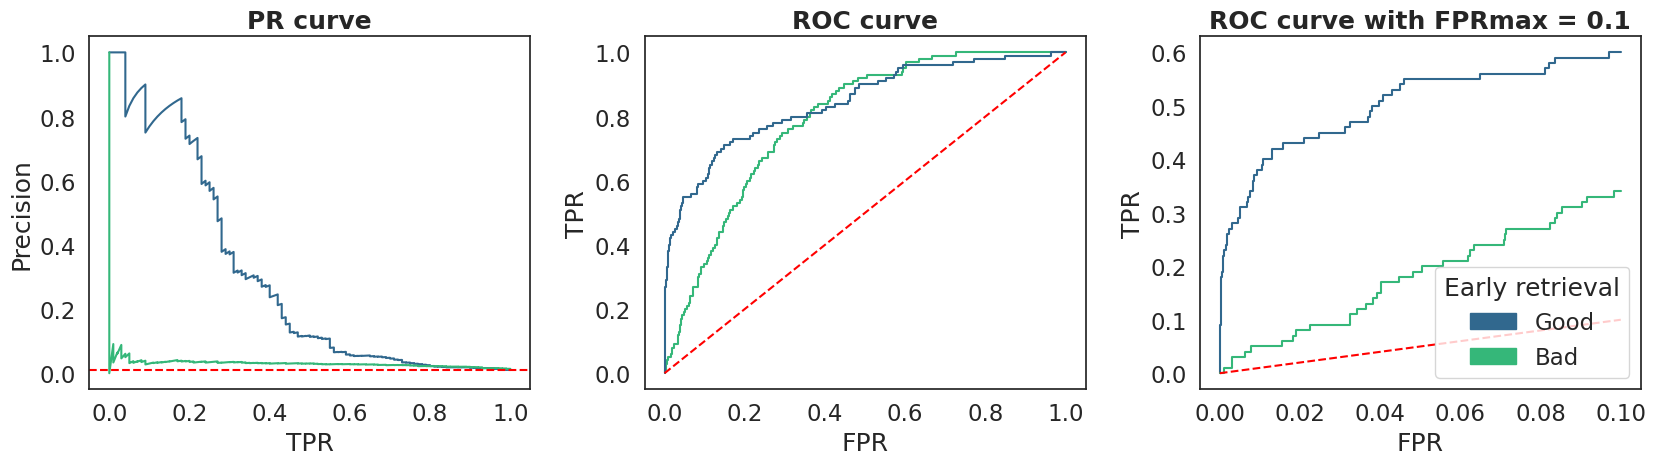

In [54]:
repeat = 1
chosen_imbalance = .01
colors = sns.color_palette("viridis", n_colors=2)
fig, axs = plt.subplots(1,3,figsize=(17,5))

labels, scores = datasets_er[repeat][(chosen_imbalance, 'good')]
precision, recall, _ = precision_recall_curve(labels, scores)
fpr, tpr, _ = roc_curve(labels, scores)
axs[0].plot(recall,precision,color=colors[0])

labels, scores = datasets_er[repeat][(chosen_imbalance, 'bad')]
precision, recall, _ = precision_recall_curve(labels, scores)
fpr, tpr, _ = roc_curve(labels, scores)
axs[0].plot(recall,precision,color=colors[1])

pos_patch = mpatches.Patch(color=colors[0], label='Good')
negative_patch = mpatches.Patch(color=colors[1], label='Bad')
plt.legend(handles = [pos_patch,negative_patch],title='Early retrieval')


axs[1].plot(fpr,tpr,color=colors[1])
labels, scores = datasets_er[repeat][(chosen_imbalance, 'good')]
precision, recall, _ = precision_recall_curve(labels, scores)
fpr, tpr, _ = roc_curve(labels, scores)
axs[1].plot(fpr,tpr,color=colors[0])
axs[0].set_title('PR curve',weight='bold')
axs[1].set_title('ROC curve',weight='bold')
axs[1].set_ylabel('TPR')
axs[1].set_xlabel('FPR')
axs[0].set_xlabel('TPR')
axs[0].set_ylabel('Precision')

axs[1].plot([0,1],[0,1],color='red',linestyle='--')
axs[0].axhline(0.01,color='red',linestyle='--')

labels, scores = datasets_er[repeat][(chosen_imbalance, 'good')]
fpr, tpr, _ = roc_curve(labels, scores)
max_fpr = 0.1
stop = np.searchsorted(fpr, max_fpr, "right")
x_interp = [fpr[stop - 1], fpr[stop]]
y_interp = [tpr[stop - 1], tpr[stop]]
tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
fpr = np.append(fpr[:stop], max_fpr)
axs[2].plot(fpr, tpr, color=colors[0])

labels, scores = datasets_er[repeat][(chosen_imbalance, 'bad')]
fpr, tpr, _ = roc_curve(labels, scores)
max_fpr = 0.1
stop = np.searchsorted(fpr, max_fpr, "right")
x_interp = [fpr[stop - 1], fpr[stop]]
y_interp = [tpr[stop - 1], tpr[stop]]
tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
fpr = np.append(fpr[:stop], max_fpr)
axs[2].plot(fpr, tpr, color=colors[1])
axs[2].plot([0,0.1],[0,0.1],linestyle='--',color='red')
axs[2].set_title('ROC curve with FPRmax = 0.1',weight='bold')
axs[2].set_ylabel('TPR')
axs[2].set_xlabel('FPR')
fig.tight_layout()
plt.savefig(os.path.join(figure_dir,f'Figure4B_Type2_{chosen_imbalance}.png'), dpi = 600, bbox_inches = 'tight')

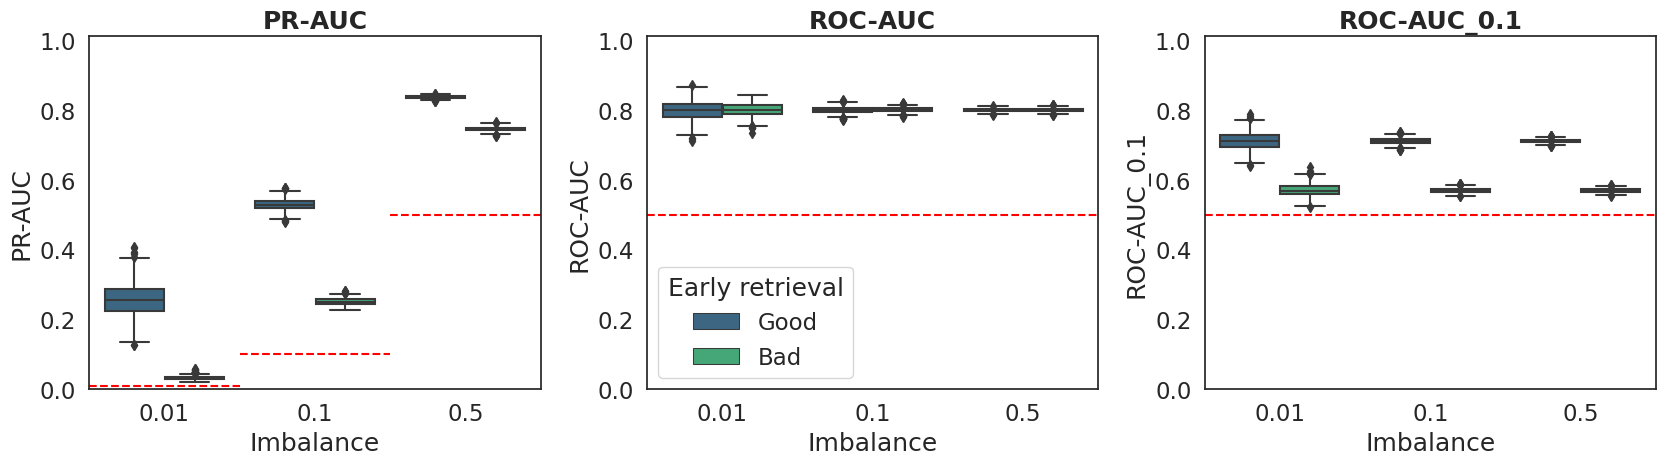

In [55]:
fig, axs = plt.subplots(1,3,figsize=(17,5))
sns.boxplot(data = pr_estimates_er, x='imbalance', y ='PR-AUC', hue = 'mean_diff', ax = axs[0], palette = 'viridis')
axs[0].set_xlabel('Imbalance')
axs[0].set_ylim(0,1.01)
axs[0].set_ylabel('PR-AUC')
axs[0].set_title(f"PR-AUC",weight='bold')
axs[0].get_legend().remove()
total_size = len(imbalances)
for k in range(len(imbalances)):
  imbalance = imbalances[k]
  axs[0].axhline(imbalance,color='red',xmin=k/total_size+0., xmax=k/total_size+(1/total_size), linestyle='--')

sns.boxplot(data = pr_estimates_er, x='imbalance', y ='ROC-AUC', hue = 'mean_diff', ax = axs[1], palette = 'viridis')
axs[1].set_xlabel('Imbalance')
axs[1].get_legend().set_title('Mean difference')
axs[1].set_ylim(0,1.01)
axs[1].set_ylabel('ROC-AUC')
axs[1].set_title(f"ROC-AUC",weight='bold')
axs[1].axhline(0.5,linestyle='--',color='red')
axs[1].get_legend().set_title('Early retrieval')

sns.boxplot(data = pr_estimates_er, x='imbalance', y ='ROC-AUC_0.1', hue = 'mean_diff', ax = axs[2], palette = 'viridis')
axs[2].set_xlabel('Imbalance')
axs[2].set_ylim(0,1.01)
axs[2].set_ylabel('ROC-AUC_0.1')
axs[2].set_title(f"ROC-AUC_0.1",weight='bold')
axs[2].get_legend().remove()
axs[2].axhline(0.5,linestyle='--',color='red')

fig.tight_layout()
plt.savefig(os.path.join(figure_dir, f'Fig1_ER.png'), dpi = 600, bbox_inches = 'tight')

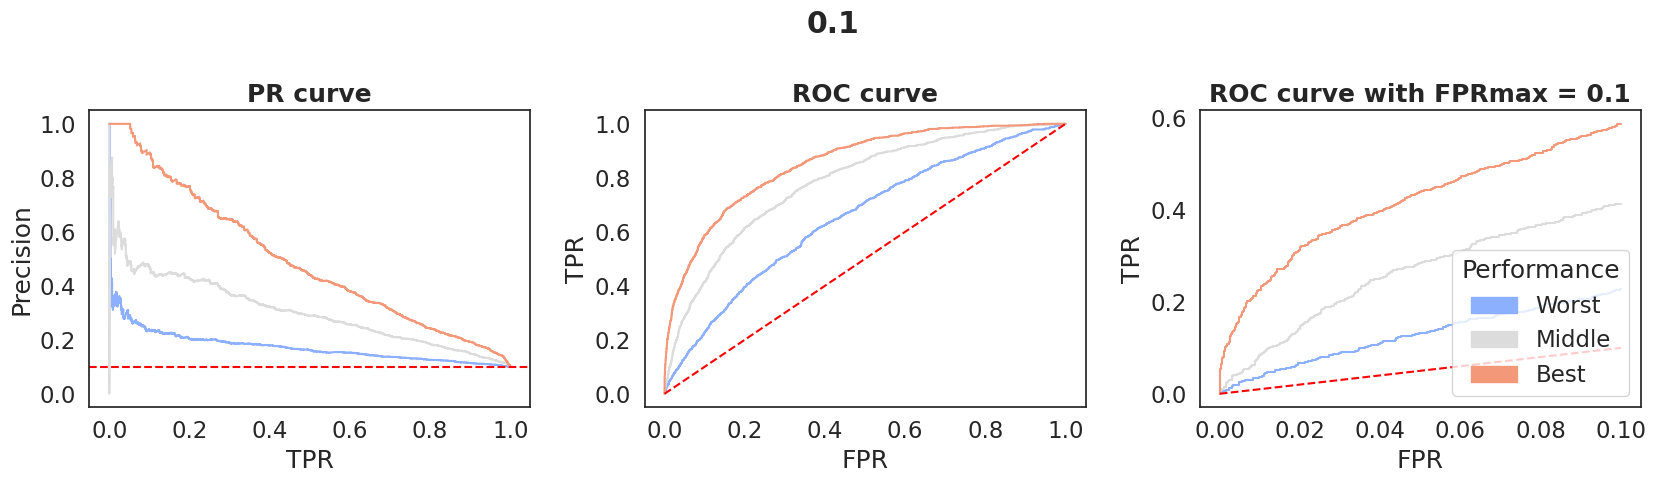

In [56]:
repeat = 1
chosen_imbalance = 0.1
dtype = 'Normal'
max_fpr = .1
dataset_dict = datasets_er if dtype == 'ER' else datasets

if dtype == 'ER':
  colors = sns.color_palette("viridis", n_colors=2)
else:
  colors = sns.color_palette("coolwarm", n_colors=3)

fig, axs = plt.subplots(1,3,figsize=(17,5))


if dtype == 'ER':
  for k,p in enumerate(['good', 'bad']):
    labels, scores = dataset_dict[repeat][(chosen_imbalance, p)]
    precision, recall, _ = precision_recall_curve(labels, scores)
    fpr, tpr, _ = roc_curve(labels, scores)
    axs[0].plot(recall,precision,color=colors[k])
    axs[1].plot(fpr,tpr,color=colors[k])
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    axs[2].plot(fpr, tpr, color=colors[k])
  axs[1].plot([0,1],[0,1], color='red', linestyle='--')
  axs[0].axhline(imbalance, color='red', linestyle='--')
  axs[2].plot([0,0.1],[0,0.1],linestyle='--',color='k')
  pos_patch = mpatches.Patch(color=colors[0], label='Good')
  negative_patch = mpatches.Patch(color=colors[1], label='Bad')
  plt.legend(handles = [pos_patch,negative_patch],title='Early retrieval')
else:
  for k,p in enumerate(mean_diffs):
    labels, scores = dataset_dict[repeat][(chosen_imbalance, p)]
    precision, recall, _ = precision_recall_curve(labels, scores)
    fpr, tpr, _ = roc_curve(labels, scores)
    axs[0].plot(recall,precision,color=colors[k])
    axs[1].plot(fpr,tpr,color=colors[k])
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    axs[2].plot(fpr, tpr, color=colors[k])
  axs[1].plot([0,1],[0,1], color='red', linestyle='--')
  axs[0].axhline(chosen_imbalance, color='red', linestyle='--')
  axs[2].plot([0,0.1],[0,0.1],linestyle='--',color='red')
  pos_patch = mpatches.Patch(color=colors[0], label='Worst')
  negative_patch = mpatches.Patch(color=colors[1], label='Middle')
  third_patch = mpatches.Patch(color=colors[2], label='Best')
  plt.legend(handles = [pos_patch,negative_patch,third_patch],title='Performance')

axs[0].set_title('PR curve',weight='bold')
axs[1].set_title('ROC curve',weight='bold')
axs[1].set_ylabel('TPR')
axs[1].set_xlabel('FPR')
axs[0].set_xlabel('TPR')
axs[0].set_ylabel('Precision')
axs[2].set_title('ROC curve with FPRmax = 0.1',weight='bold')
axs[2].set_ylabel('TPR')
axs[2].set_xlabel('FPR')
plt.suptitle(chosen_imbalance, weight='bold')
fig.tight_layout()
plt.savefig(os.path.join(figure_dir,f'Figure4B_{dtype}.png'), dpi = 600, bbox_inches = 'tight')

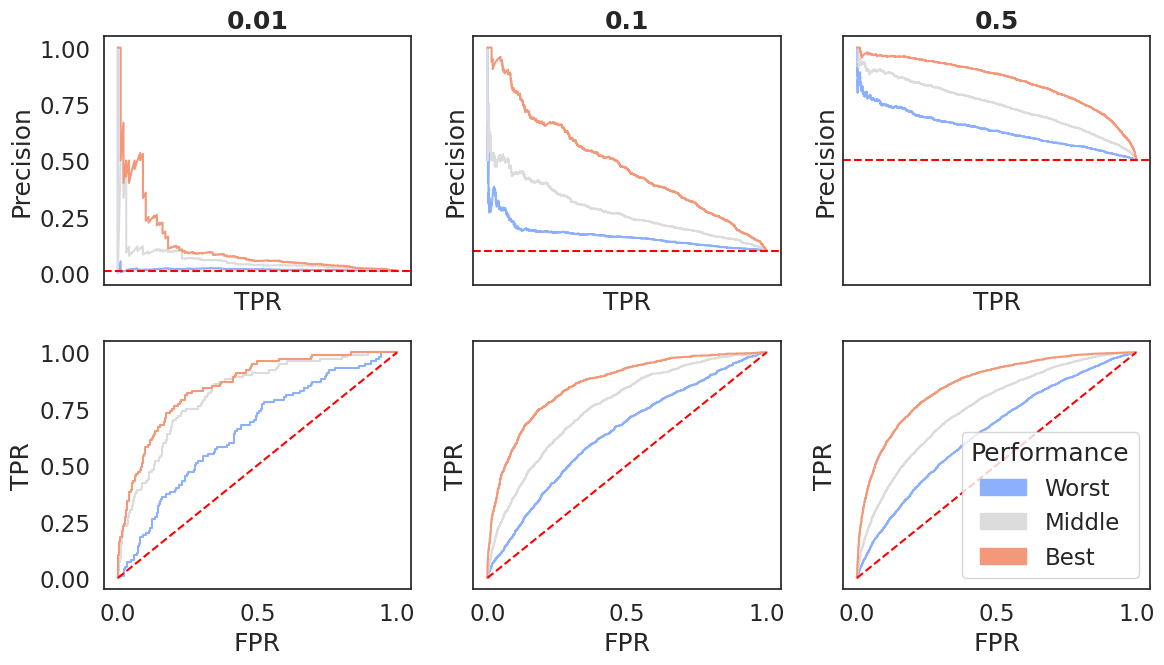

In [57]:
dtype = 'Normal'
dataset_dict = datasets_er if dtype == 'ER' else datasets

if dtype == 'ER':
  colors = sns.color_palette("viridis", n_colors=2)
else:
  colors = sns.color_palette("coolwarm", n_colors=3)

fig, axs = plt.subplots(2,3,figsize=(12,7),sharex=True,sharey=True)

repeat = np.random.randint(len(dataset_dict))

if dtype == 'ER':
  for k,p in enumerate(['good', 'bad']):
    labels, scores = dataset_dict[repeat][(chosen_imbalance, p)]
    precision, recall, _ = precision_recall_curve(labels, scores)
    fpr, tpr, _ = roc_curve(labels, scores)
    axs[0].plot(recall,precision,color=colors[k])
    axs[1].plot(fpr,tpr,color=colors[k])
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    axs[2].plot(fpr, tpr, color=colors[k])
  axs[1].plot([0,1],[0,1], color='red', linestyle='--')
  axs[0].axhline(imbalance, color='red', linestyle='--')
  axs[2].plot([0,0.1],[0,0.1],linestyle='--',color='k')
  pos_patch = mpatches.Patch(color=colors[0], label='Good')
  negative_patch = mpatches.Patch(color=colors[1], label='Bad')
  plt.legend(handles = [pos_patch,negative_patch],title='Early retrieval')
else:
  for n,chosen_imbalance in enumerate(imbalances[:3]):
    for k,p in enumerate(mean_diffs):
      labels, scores = dataset_dict[repeat][(chosen_imbalance, p)]
      precision, recall, _ = precision_recall_curve(labels, scores)
      fpr, tpr, _ = roc_curve(labels, scores)
      axs[0][n].plot(recall,precision,color=colors[k])
      axs[0][n].set_xlabel('TPR')
      axs[0][n].set_ylabel("Precision")
      axs[1][n].plot(fpr,tpr,color=colors[k])
      axs[1][n].set_xlabel('FPR')
      axs[1][n].set_ylabel('TPR')
    axs[1][n].plot([0,1],[0,1], color='red', linestyle='--')
    axs[0][n].axhline(chosen_imbalance, color='red', linestyle='--')
    pos_patch = mpatches.Patch(color=colors[0], label='Worst')
    negative_patch = mpatches.Patch(color=colors[1], label='Middle')
    third_patch = mpatches.Patch(color=colors[2], label='Best')
    plt.legend(handles = [pos_patch,negative_patch,third_patch],title='Performance')

for n,x in enumerate(imbalances[:3]):
  axs[0][n].set_title(x, weight = 'bold')


# axs[1].set_ylabel('TPR')
# axs[1].set_xlabel('FPR')
# axs[0].set_xlabel('TPR')
# axs[0].set_ylabel('Precision')
# axs[2].set_title('ROC curve with FPRmax = 0.1',weight='bold')
# axs[2].set_ylabel('TPR')
# axs[2].set_xlabel('FPR')
# plt.suptitle(chosen_imbalance, weight='bold')
fig.tight_layout()
plt.savefig(os.path.join(figure_dir,f'ROCS_{dtype}.png'), dpi = 600, bbox_inches = 'tight')

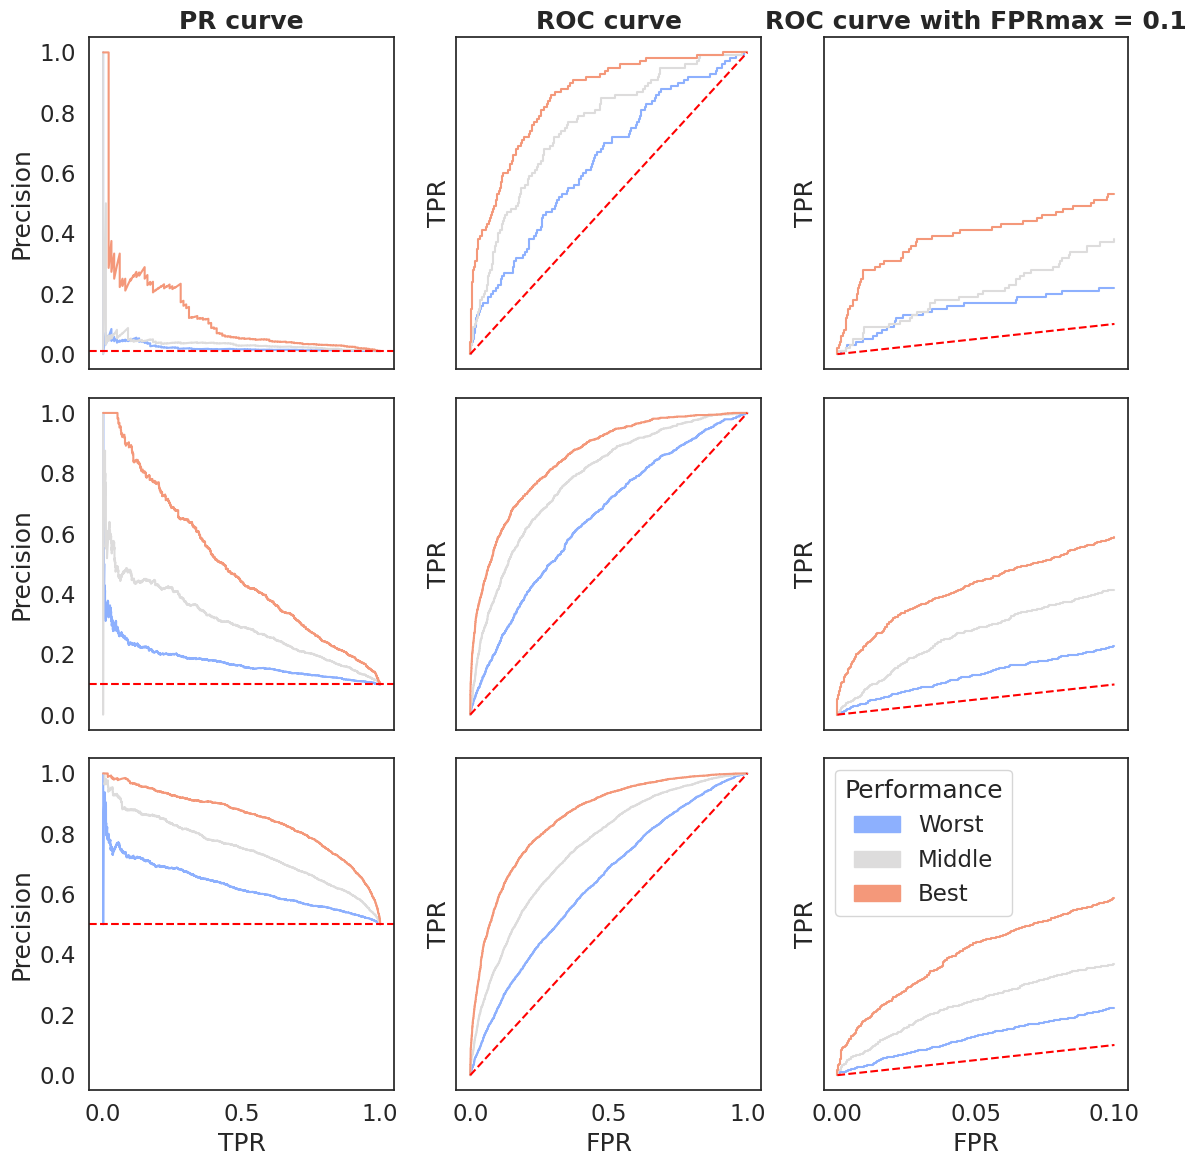

In [61]:
repeat = 1
dtype = 'Normal'
max_fpr = .1
dataset_dict = datasets_er if dtype == 'ER' else datasets

if dtype == 'ER':
  colors = sns.color_palette("viridis", n_colors=2)
else:
  colors = sns.color_palette("coolwarm", n_colors=3)

fig, axes = plt.subplots(len(imbalances),3,figsize=(12,12), sharey=True)


for x, chosen_imbalance in enumerate(imbalances):
  axs = axes[x]
  if dtype == 'ER':
    for k,p in enumerate(['good', 'bad']):
      labels, scores = dataset_dict[repeat][(chosen_imbalance, p)]
      precision, recall, _ = precision_recall_curve(labels, scores)
      fpr, tpr, _ = roc_curve(labels, scores)
      axs[0].plot(recall,precision,color=colors[k])
      axs[1].plot(fpr,tpr,color=colors[k])
      stop = np.searchsorted(fpr, max_fpr, "right")
      x_interp = [fpr[stop - 1], fpr[stop]]
      y_interp = [tpr[stop - 1], tpr[stop]]
      tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
      fpr = np.append(fpr[:stop], max_fpr)
      axs[2].plot(fpr, tpr, color=colors[k])
    axs[1].plot([0,1],[0,1], color='red', linestyle='--')
    axs[0].axhline(chosen_imbalance, color='red', linestyle='--')
    axs[2].plot([0,0.1],[0,0.1],linestyle='--',color='k')
    pos_patch = mpatches.Patch(color=colors[0], label='Good')
    negative_patch = mpatches.Patch(color=colors[1], label='Bad')
    plt.legend(handles = [pos_patch,negative_patch],title='Early retrieval')
  else:
    for k,p in enumerate(mean_diffs):
      labels, scores = dataset_dict[repeat][(chosen_imbalance, p)]
      precision, recall, _ = precision_recall_curve(labels, scores)
      fpr, tpr, _ = roc_curve(labels, scores)
      axs[0].plot(recall,precision,color=colors[k])
      axs[1].plot(fpr,tpr,color=colors[k])
      stop = np.searchsorted(fpr, max_fpr, "right")
      x_interp = [fpr[stop - 1], fpr[stop]]
      y_interp = [tpr[stop - 1], tpr[stop]]
      tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
      fpr = np.append(fpr[:stop], max_fpr)
      axs[2].plot(fpr, tpr, color=colors[k])
    axs[1].plot([0,1],[0,1], color='red', linestyle='--')
    axs[0].axhline(chosen_imbalance, color='red', linestyle='--')
    axs[2].plot([0,0.1],[0,0.1],linestyle='--',color='red')
    pos_patch = mpatches.Patch(color=colors[0], label='Worst')
    negative_patch = mpatches.Patch(color=colors[1], label='Middle')
    third_patch = mpatches.Patch(color=colors[2], label='Best')
    plt.legend(handles = [pos_patch,negative_patch,third_patch],title='Performance')
    if x == 0:
      axs[0].set_title('PR curve',weight='bold')
      axs[1].set_title('ROC curve',weight='bold')
      axs[2].set_title('ROC curve with FPRmax = 0.1',weight='bold')
    axs[0].set_xlabel('TPR')
    axs[1].set_ylabel('TPR')
    axs[1].set_xlabel('FPR')
    axs[0].set_ylabel('Precision')
    axs[2].set_ylabel('TPR')
    axs[2].set_xlabel('FPR')
    if x != len(imbalances) - 1:
      axs[0].set_xticks([])
      axs[1].set_xticks([])
      axs[2].set_xticks([])
      axs[0].set_xlabel('')
      axs[1].set_xlabel('')
      axs[2].set_xlabel('')
fig.tight_layout()
plt.savefig(os.path.join(figure_dir,f'Figure4B_{dtype}_AllImbalances.png'), dpi = 600, bbox_inches = 'tight')

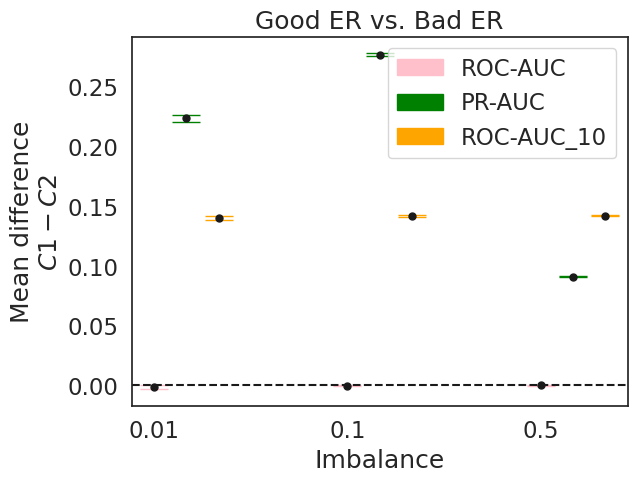

In [59]:

fig, ax = plt.subplots(1,1)
#ylabel = 'Relative difference\n'+r"$(\frac{C1 - C2}{C2})$"
ylabel = 'Mean difference\n'+r"$C1 - C2$"
pr_estimates_diff_er = calc_pr_estimates_diff(pr_estimates_er, ['Good','Bad'], norm = False)
pr_estimates_diff_er['p'] = pr_estimates_diff_er['p1'].map(str)+'_'+pr_estimates_diff_er['p2'].map(str)
comparison = 'Good_Bad'
mean_list = list(pr_estimates_diff_er[pr_estimates_diff_er['p']==comparison]['mean_diff'].values)
W_list = list(pr_estimates_diff_er[pr_estimates_diff_er['p']==comparison]['err'].values)
metric_types = ['ROC-AUC','PR-AUC','ROC-AUC_0.1']
colors = ['pink','green','orange']
index = .75
imbalances = [.01]
x_coords = [index]
first_balance = pr_estimates_diff_er[pr_estimates_diff_er['p']==comparison].iloc[0]['imbalance']
for x,(k,p) in enumerate(pr_estimates_diff_er[pr_estimates_diff_er['p']==comparison].iterrows()):
    color = colors[metric_types.index(p.metric)]
    if x != 0:

      if p.imbalance != first_balance:
        index += 1
        imbalances.append(p.imbalance)
        x_coords.append(index)
      else:
        index += .25

      first_balance = p.imbalance
    ax.errorbar(y=[p.mean_diff], x=index, yerr=[p.err], fmt='o', ms=5, color='k',capthick=1,ecolor=color,capsize=10)
ax.axhline(0,linestyle='--',color='k')
ax.set_xticks(x_coords, imbalances)
red_patch = mpatches.Patch(color='pink', label='ROC-AUC')
pink_patch = mpatches.Patch(color='green', label='PR-AUC')
orange_patch = mpatches.Patch(color='orange', label='ROC-AUC_10')
plt.legend(handles = [red_patch,pink_patch,orange_patch])
ax.set_xlabel('Imbalance')
ax.set_ylabel(ylabel)
ax.set_title(f'Good ER vs. Bad ER')
plt.savefig(os.path.join(figure_dir,f'GoodvsBadER_NoNorm.png'), dpi = 600, bbox_inches = 'tight')

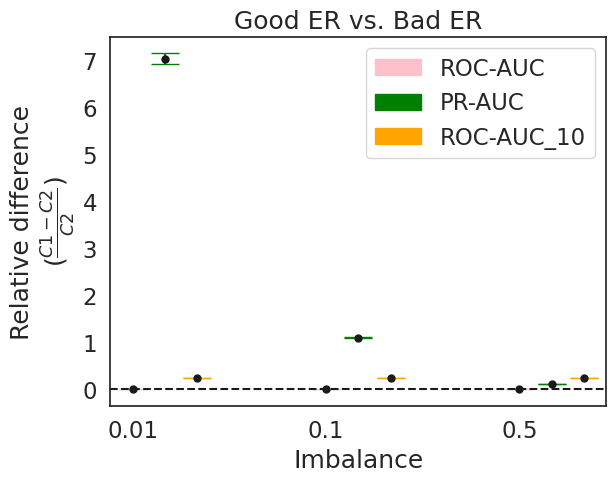

In [60]:
fig, ax = plt.subplots(1,1)
pr_estimates_diff_er = calc_pr_estimates_diff(pr_estimates_er, ['Good','Bad'], norm = True)
ylabel = 'Relative difference\n'+r"$(\frac{C1 - C2}{C2})$"
#ylabel = 'Mean difference (Worse classifier - Better classifier)'
pr_estimates_diff_er['p'] = pr_estimates_diff_er['p1'].map(str)+'_'+pr_estimates_diff_er['p2'].map(str)
comparison = 'Good_Bad'
mean_list = list(pr_estimates_diff_er[pr_estimates_diff_er['p']==comparison]['mean_diff'].values)
W_list = list(pr_estimates_diff_er[pr_estimates_diff_er['p']==comparison]['err'].values)
metric_types = ['ROC-AUC','PR-AUC','ROC-AUC_0.1']
colors = ['pink','green','orange']
index = .75
imbalances = [.01]
x_coords = [index]
first_balance = pr_estimates_diff_er[pr_estimates_diff_er['p']==comparison].iloc[0]['imbalance']
for x,(k,p) in enumerate(pr_estimates_diff_er[pr_estimates_diff_er['p']==comparison].iterrows()):
    color = colors[metric_types.index(p.metric)]
    if x != 0:

      if p.imbalance != first_balance:
        index += 1
        imbalances.append(p.imbalance)
        x_coords.append(index)
      else:
        index += .25

      first_balance = p.imbalance
    ax.errorbar(y=[p.mean_diff], x=index, yerr=[p.err], fmt='o', ms=5, color='k',capthick=1,ecolor=color,capsize=10)
ax.axhline(0,linestyle='--',color='k')
ax.set_xticks(x_coords, imbalances)
red_patch = mpatches.Patch(color='pink', label='ROC-AUC')
pink_patch = mpatches.Patch(color='green', label='PR-AUC')
orange_patch = mpatches.Patch(color='orange', label='ROC-AUC_10')
plt.legend(handles = [red_patch,pink_patch,orange_patch])
ax.set_xlabel('Imbalance')
ax.set_ylabel(ylabel)
ax.set_title(f'Good ER vs. Bad ER')
plt.savefig(os.path.join(figure_dir,f'GoodvsBadER_Relative.png'), dpi = 600, bbox_inches = 'tight')

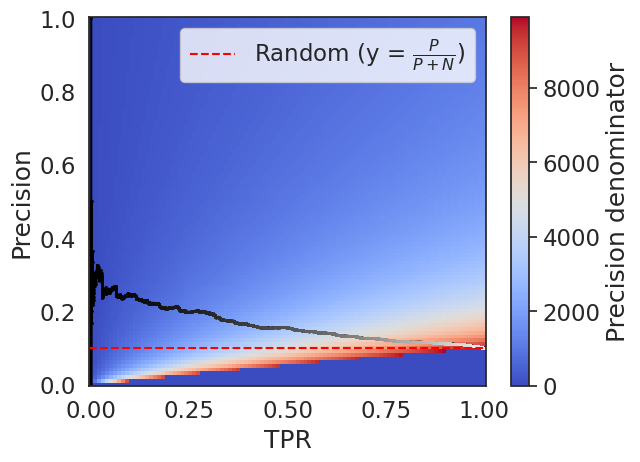

In [ ]:
def return_matrix(predictions, true, aim_p, aim_r):
    friends = list(zip(predictions, true))
    if aim_r == 0:
      return -10, -10
    if aim_p == 0:
      return -10, -10
    ir = int(aim_r * sum(true))
    total_preds = int(np.ceil(ir*(1/aim_p)))
    negs = total_preds - ir
    if total_preds > len(predictions):
      return -10, -10
    else:
      pos = [1 for p in friends if p[1]==1]
      neg = [1 for p in friends if p[1]==0]
      if ir <= len(pos):
        if negs <= len(neg):
          pos = pos[:ir]
          neg = neg[:negs]
          assert len(pos)+len(neg)==total_preds
          return np.hstack([np.ones(len(pos)), np.zeros(len(neg))]), np.hstack([np.array(pos), np.array(neg)])
        else:
          return -10, -10
      else:
        return -10, -10
example = datasets[np.random.randint(len(datasets))][(0.1, 0.5)]
mesh_x = np.linspace(0, 1.00, 100)
mesh_y = np.linspace(0, 1.00, 100)
dataset_size = dict()
for recall in mesh_x:
  dataset_size[recall] = dict()
  for precision in mesh_y:
    X, y = return_matrix(example[1], example[0], precision, recall)
    if type(X)==int:
      dataset_size[recall][precision] = X
    elif len(set(y))>1:
      tn, fp, fn, tp = confusion_matrix(X,y).ravel()
      dataset_size[recall][precision] = sum([tp,fp,fn])
    else:
      dataset_size[recall][precision] = len(X)

dataset_size = pd.DataFrame(dataset_size)
p, r, _ = precision_recall_curve(*example)
fig, ax = plt.subplots(1,1)
ax.plot(r,p,color='black')
color_scheme = sns.color_palette("binary", n_colors=len(_)+1)
for re, pr, col in zip(r, p, color_scheme):
  ax.plot(re,pr, '.', ms = 2, color = col)
cf = ax.pcolormesh(dataset_size.index, dataset_size.columns, dataset_size, cmap = 'coolwarm')
#cf = ax.contourf([p for p in dataset_size.index], dataset_size.columns, dataset_size, cmap = 'coolwarm', levels = levels)
ax.set_ylabel('Precision')
ax.set_xlabel('TPR')
fig.colorbar(cf, ax=ax, label = 'Precision denominator')
ax.axhline(0.1,color='red', linestyle = '--')
line = Line2D([0], [0], label=r'Random (y = $\frac{P}{P+N}$)', color='red', linestyle = '--')
handles, labels = plt.gca().get_legend_handles_labels()
handles = [line]
plt.legend(handles=handles)
plt.savefig(os.path.join(figure_dir, 'ChangingDenominator.png'), dpi = 600, bbox_inches = 'tight')